In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Consensus between two colors ("RED" and "BLUE")

class Simulator:
    END_EPOCH = 100
    
    def __init__(self, validator_num, slots_per_epoch, fault_tolerance, init_red_honest_ratio, init_red_adversary_ratio):
        self.validator_num = validator_num
        self.slots_per_epoch = slots_per_epoch
        self.fault_tolerance = fault_tolerance

        self.validator_id_list = list(range(self.validator_num))
        self.adversary_num = math.ceil(self.validator_num * self.fault_tolerance) - 1
        self.adversary_ids = set(self.validator_id_list[: self.adversary_num])
        self.honest_ids = set(self.validator_id_list[self.adversary_num:])
        assert self.validator_num == len(self.honest_ids) + len(self.adversary_ids)

        # Initial score of RED (RED is the initial winner)
        init_red_honest_ids = set(random.sample(self.honest_ids, math.ceil(self.validator_num * init_red_honest_ratio))) # Honest validators voting for RED
        init_red_adversary_ids = set(random.sample(self.adversary_ids, math.ceil(self.validator_num * init_red_adversary_ratio))) # Adversarial validators voting for RED

        # Latest votes for two colors
        # Index: 0 -> RED, 1 -> BLUE
        self.votes = [{"honest_ids": init_red_honest_ids, "adversary_ids": init_red_adversary_ids},
                      {"honest_ids": self.honest_ids - init_red_honest_ids, "adversary_ids": self.adversary_ids - init_red_adversary_ids}]
                                     
        # Slot, epoch
        self.slot = 0
        self.epoch = 0
        self.voters_per_slot = self.validator_num // self.slots_per_epoch
        self.slot_allocation = self.validator_id_list
        
        # Log for visualization
        self.pivots = np.zeros(Simulator.END_EPOCH)  # Number of pivots in the epoch
        self.scores = np.zeros(int(Simulator.END_EPOCH * self.slots_per_epoch * 2 * 2)).reshape(int(Simulator.END_EPOCH * self.slots_per_epoch), 2, 2)  # Index: slot * epoch -> honest/adversary -> red/blue
        
    def get_red_score(self):
        return len(self.votes[0]["honest_ids"]) + len(self.votes[0]["adversary_ids"])

    def get_blue_score(self):
        return len(self.votes[1]["honest_ids"]) + len(self.votes[1]["adversary_ids"])

    
    def get_winner(self):
        if self.get_red_score() > self.get_blue_score():
            return 0
        elif self.get_red_score() == self.get_blue_score() and self.votes[0]["honest_ids"] >= self.votes[1]["honest_ids"]:
            # If there is a tie, adversasy assumes the worst tie-breaking
            return 0
        return 1

    
    def get_current_voters(self):
        offset = int(self.voters_per_slot * (self.slot % self.slots_per_epoch))
        return set(self.slot_allocation[offset: offset + self.voters_per_slot])

    def batch_vote(self, target, validator_ids):
        non_target = (target + 1) % 2
        self.votes[non_target]["honest_ids"] -= validator_ids
        self.votes[non_target]["adversary_ids"] -= validator_ids
        self.votes[target]["honest_ids"] |= validator_ids & self.honest_ids
        self.votes[target]["adversary_ids"] |= validator_ids & self.adversary_ids
        assert self.votes[non_target]["honest_ids"] | self.votes[target]["honest_ids"] == self.honest_ids
        assert self.votes[non_target]["adversary_ids"] | self.votes[target]["adversary_ids"] == self.adversary_ids
        self.scores[self.slot][0][0] = len(self.votes[0]["honest_ids"])
        self.scores[self.slot][0][1] = len(self.votes[1]["honest_ids"])
        self.scores[self.slot][1][0] = len(self.votes[0]["adversary_ids"])
        self.scores[self.slot][1][1] = len(self.votes[1]["adversary_ids"])
        
    
    def decoy_flip_flop(self):
        winner = self.get_winner()
        # Adversary calculates the maximum increase of the honest votes for the winner
        # NOTE: This can be upper bounded by the number of validators who havn't voted yet and whose latest votes are not for the winner
        honest_vote_num = self.voters_per_slot - len(self.get_current_voters() & self.adversary_ids)
        # Pivoting rule
        if len(self.votes[winner]["honest_ids"]) + honest_vote_num > math.ceil(self.validator_num / 2) - 1:
            new_winner = (winner + 1) % 2
            self.batch_vote(new_winner, self.adversary_ids)
            assert self.get_winner() != winner, "Pivoting failed!"
            # Save the log
            self.pivots[self.epoch] += 1

    def process_slot(self):
        # Before this slot starts, adversary make pivot in some cases
        self.decoy_flip_flop()
        winner = self.get_winner()
        self.batch_vote(winner, self.get_current_voters() & self.honest_ids)
        self.slot += 1

    def process_epoch(self):
        random.shuffle(self.slot_allocation)
        self.epoch += 1
        
    def run(self):
        random.shuffle(self.slot_allocation)
        while self.epoch < Simulator.END_EPOCH:
            self.process_slot()
            if self.slot % self.slots_per_epoch == 0:
                self.process_epoch()
                

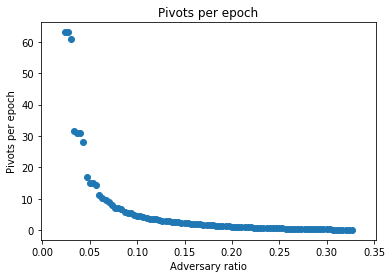

In [3]:
# Parameters
SLOTS_PER_EPOCH = 64
VALIDATOR_NUM = 131072  # Minimum of ETH2.0
assert VALIDATOR_NUM % SLOTS_PER_EPOCH == 0

# Unlucky initial state for adversary
INIT_RED_HONEST_RATIO = 49 / 100  # Must be < 1/2
INIT_RED_ADVERSARY_RATIO = 2 / 100
assert INIT_RED_HONEST_RATIO + INIT_RED_ADVERSARY_RATIO > 1/2


TRIAL_NUM = 92
data_x = np.zeros(TRIAL_NUM)
data_y = np.zeros(TRIAL_NUM)

for i in range(TRIAL_NUM):
    FAULT_TOLERANCE = 1 / 3 * (i + 7) / 100
    assert INIT_RED_ADVERSARY_RATIO < FAULT_TOLERANCE
    s = Simulator(VALIDATOR_NUM, SLOTS_PER_EPOCH, FAULT_TOLERANCE, INIT_RED_HONEST_RATIO, INIT_RED_ADVERSARY_RATIO)
    s.run()  
    data_x[i] = FAULT_TOLERANCE
    data_y[i] = (np.sum(s.pivots) - s.epoch) / s.epoch


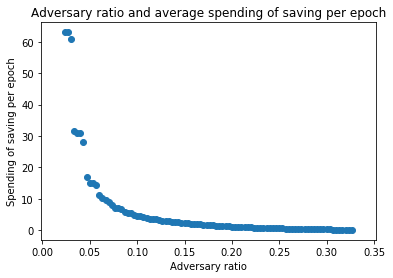

In [8]:
%matplotlib inline
plt.title('Adversary ratio and average spending of saving per epoch')
plt.xlabel('Adversary ratio')
plt.ylabel('Spending of saving per epoch')

plt.scatter(data_x, data_y)

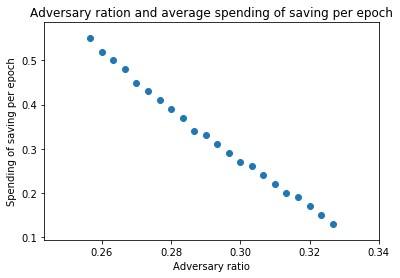

In [7]:
plt.title('Adversary ration and average spending of saving per epoch')
plt.xlabel('Adversary ratio')
plt.ylabel('Spending of saving per epoch')

plt.scatter(data_x[70:], data_y[70:])

In [9]:
data_y[70:]

array([0.55, 0.52, 0.5 , 0.48, 0.45, 0.43, 0.41, 0.39, 0.37, 0.34, 0.33,
       0.31, 0.29, 0.27, 0.26, 0.24, 0.22, 0.2 , 0.19, 0.17, 0.15, 0.13])